In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('FAOSTAT_data_en_7-29-2025.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: FAOSTAT_data_en_7-29-2025.csv not found. Please ensure the file is in the correct directory.")
    exit()

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
df.info()

# Display columns to check for any leading/trailing spaces in column
print("\nColumn names:")
print(df.columns)

Dataset loaded successfully.

First 5 rows of the dataset:
  Domain Code    Domain  Area Code (M49)    Area  Element Code Element  \
0          RL  Land Use              646  Rwanda          5110    Area   
1          RL  Land Use              646  Rwanda          5110    Area   
2          RL  Land Use              646  Rwanda          5110    Area   
3          RL  Land Use              646  Rwanda          5110    Area   
4          RL  Land Use              646  Rwanda          5110    Area   

   Item Code          Item  Year Code  Year     Unit   Value Flag  \
0       6600  Country area       1961  1961  1000 ha  2634.0    A   
1       6600  Country area       1962  1962  1000 ha  2634.0    A   
2       6600  Country area       1963  1963  1000 ha  2634.0    A   
3       6600  Country area       1964  1964  1000 ha  2634.0    A   
4       6600  Country area       1965  1965  1000 ha  2634.0    A   

  Flag Description  Note  
0  Official figure   NaN  
1  Official figure   NaN  


In [2]:
print("\nMissing values before cleaning:")
print(df.isnull().sum())


Missing values before cleaning:
Domain Code            0
Domain                 0
Area Code (M49)        0
Area                   0
Element Code           0
Element                0
Item Code              0
Item                   0
Year Code              0
Year                   0
Unit                   0
Value                  0
Flag                   0
Flag Description       0
Note                1675
dtype: int64


In [3]:
# Drop columns with more than 50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)
print(f"\nShape after dropping columns with >50% missing values: {df.shape}")

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include='object').columns

# Impute missing numerical values with the median
for col in numerical_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# Impute missing categorical values with the mode
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")

print("\nMissing values after imputation:")
print(df.isnull().sum())


Shape after dropping columns with >50% missing values: (1675, 14)

Missing values after imputation:
Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code           0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64


In [4]:
# Convert 'Value' column to numeric, coercing errors
if 'Value' in df.columns:
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    # After coercing, check for and handle newly created NaNs if any
    if df['Value'].isnull().any():
        median_value = df['Value'].median()
        df['Value'].fillna(median_value, inplace=True)
        print(f"Converted 'Value' to numeric and filled new NaNs with median: {median_value}")

# Strip whitespace from object columns
for col in categorical_cols:
    df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
print("\nTrimmed whitespace from categorical columns.")

# Standardize 'Unit' column if present
if 'Unit' in df.columns:
    # Example: Convert all 'tonnes' to 'tons' (or standardize to one form)
    df['Unit'] = df['Unit'].replace({'tonnes': 'tons', 'Tons': 'tons'})
    print("\nStandardized 'Unit' column (example: 'tonnes' to 'tons').")


Trimmed whitespace from categorical columns.

Standardized 'Unit' column (example: 'tonnes' to 'tons').


In [5]:
# Outlier handling for 'Value' column using IQR
if 'Value' in df.columns and pd.api.types.is_numeric_dtype(df['Value']):
    Q1 = df['Value'].quantile(0.25)
    Q3 = df['Value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df['Value'] = np.where(df['Value'] < lower_bound, lower_bound, df['Value'])
    df['Value'] = np.where(df['Value'] > upper_bound, upper_bound, df['Value'])
    print(f"\nCapped outliers in 'Value' column using IQR. Lower bound: {lower_bound}, Upper bound: {upper_bound}")


Capped outliers in 'Value' column using IQR. Lower bound: -1078.6875, Upper bound: 1855.2125


In [6]:
# Select a few relevant categorical columns for encoding
# Choose columns that are likely to be useful for modeling and have manageable unique values
# Let's assume 'Area', 'Item', and 'Element' are important if they have a reasonable number of unique values.
# Check unique values first
print("\nUnique values in potential categorical columns for encoding:")
for col in ['Area', 'Item', 'Element']: # Example columns, adjust based on your df.columns
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")

# Apply one-hot encoding to selected categorical columns
# We will encode 'Area', 'Item', 'Element' if they exist and have a reasonable number of unique values
# A reasonable number might be less than 50 or 100, depending on computational resources.
cols_to_encode = []
for col in ['Area', 'Item', 'Element']:
    if col in df.columns and df[col].nunique() < 100: # Adjust threshold as needed
        cols_to_encode.append(col)

if cols_to_encode:
    df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True) # drop_first to avoid multicollinearity
    print(f"\nApplied one-hot encoding to: {cols_to_encode}")
else:
    print("\nNo suitable categorical columns found for one-hot encoding with current criteria.")

print("\nShape after one-hot encoding:", df.shape)
print("Columns after encoding:", df.columns)


Unique values in potential categorical columns for encoding:
Area: 1 unique values
Item: 23 unique values
Element: 8 unique values

Applied one-hot encoding to: ['Area', 'Item', 'Element']

Shape after one-hot encoding: (1675, 40)
Columns after encoding: Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 'Item Code',
       'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description',
       'Item_Agriculture', 'Item_Agriculture area actually irrigated',
       'Item_Agriculture area certified organic',
       'Item_Agriculture area under organic agric.', 'Item_Arable land',
       'Item_Country area', 'Item_Cropland',
       'Item_Cropland area certified organic',
       'Item_Cropland area under organic agric.', 'Item_Forest land',
       'Item_Inland waters', 'Item_Land area',
       'Item_Land area equipped for irrigation',
       'Item_Naturally regenerating forest', 'Item_Other land',
       'Item_Permanent crops', 'Item_Permanent meadows and pastures',
     

In [7]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns for scaling (excluding encoded dummy variables and 'Year' if it's treated as a feature)
# Ensure 'Value' is numerical, and potentially other numerical columns like 'Year' if it's used as a numerical feature
numerical_cols_for_scaling = df.select_dtypes(include=np.number).columns.tolist()

# Remove columns that were just created by one-hot encoding (they are already 0/1)
# Also, 'Year' might not need scaling if it's treated as a time feature or used for grouping
cols_to_exclude_from_scaling = [col for col in df.columns if '_ID' in col or 'Flag' in col or col == 'Year'] # Adjust based on your columns
numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col not in cols_to_exclude_from_scaling]

if numerical_cols_for_scaling:
    scaler = StandardScaler()
    df[numerical_cols_for_scaling] = scaler.fit_transform(df[numerical_cols_for_scaling])
    print(f"\nScaled numerical columns: {numerical_cols_for_scaling}")
else:
    print("\nNo numerical columns found for scaling with current criteria.")

print("\nFirst 5 rows after data cleaning and transformations:")
print(df.head())


Scaled numerical columns: ['Area Code (M49)', 'Element Code', 'Item Code', 'Year Code', 'Value']

First 5 rows after data cleaning and transformations:
  Domain Code    Domain  Area Code (M49)  Element Code  Item Code  Year Code  \
0          RL  Land Use              0.0      -0.24609  -1.263791  -1.958179   
1          RL  Land Use              0.0      -0.24609  -1.263791  -1.902226   
2          RL  Land Use              0.0      -0.24609  -1.263791  -1.846272   
3          RL  Land Use              0.0      -0.24609  -1.263791  -1.790318   
4          RL  Land Use              0.0      -0.24609  -1.263791  -1.734365   

   Year     Unit     Value Flag  ... Item_Temporary crops  \
0  1961  1000 ha  2.099364    A  ...                False   
1  1962  1000 ha  2.099364    A  ...                False   
2  1963  1000 ha  2.099364    A  ...                False   
3  1964  1000 ha  2.099364    A  ...                False   
4  1965  1000 ha  2.099364    A  ...                False   


In [8]:
print("\nDescriptive statistics for numerical columns:")
print(df.describe())

print("\nDescriptive statistics for categorical (original) columns:")
# Before encoding, let's see some unique values and counts for original categorical columns
# We need to reload or keep a copy of original df for this, or just look at the remaining object columns
# Let's get the info from the current df, for any remaining object columns
for col in df.select_dtypes(include='object').columns:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())


Descriptive statistics for numerical columns:
       Area Code (M49)  Element Code     Item Code     Year Code         Year  \
count           1675.0  1.675000e+03  1.675000e+03  1.675000e+03  1675.000000   
mean               0.0 -3.393637e-17  3.733001e-15  4.012976e-15  1995.996418   
std                0.0  1.000299e+00  1.000299e+00  1.000299e+00    17.877253   
min                0.0 -2.460900e-01 -1.263791e+00 -1.958179e+00  1961.000000   
25%                0.0 -2.460900e-01 -6.952497e-01 -8.391052e-01  1981.000000   
50%                0.0 -2.460900e-01  4.385406e-02  1.121079e-01  1998.000000   
75%                0.0 -2.221983e-02  7.261037e-01  8.395061e-01  2011.000000   
max                0.0  6.904209e+00  2.062176e+00  1.510951e+00  2023.000000   

             Value  
count  1675.000000  
mean      0.000000  
std       1.000299  
min      -0.720559  
25%      -0.687856  
50%      -0.602576  
75%       0.427032  
max       2.099364  

Descriptive statistics for catego

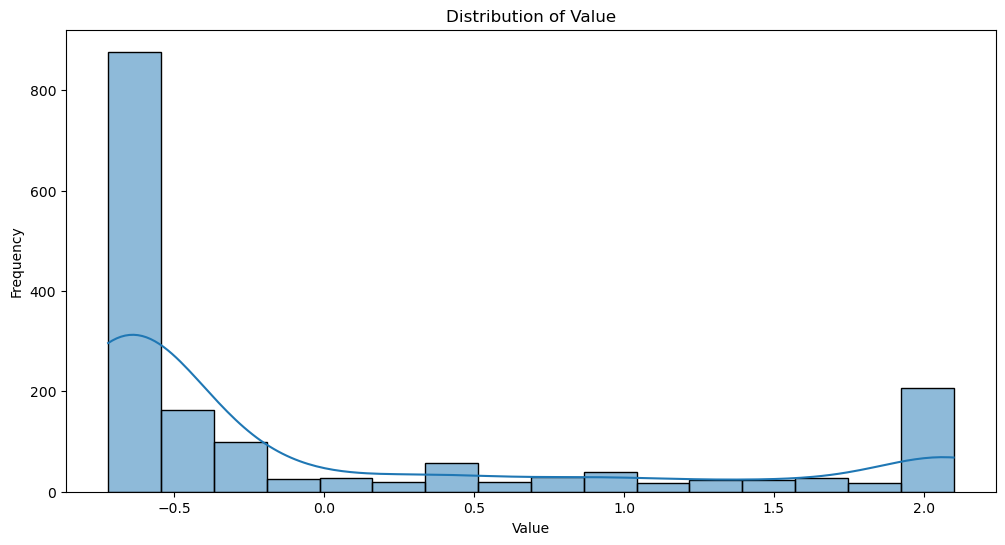

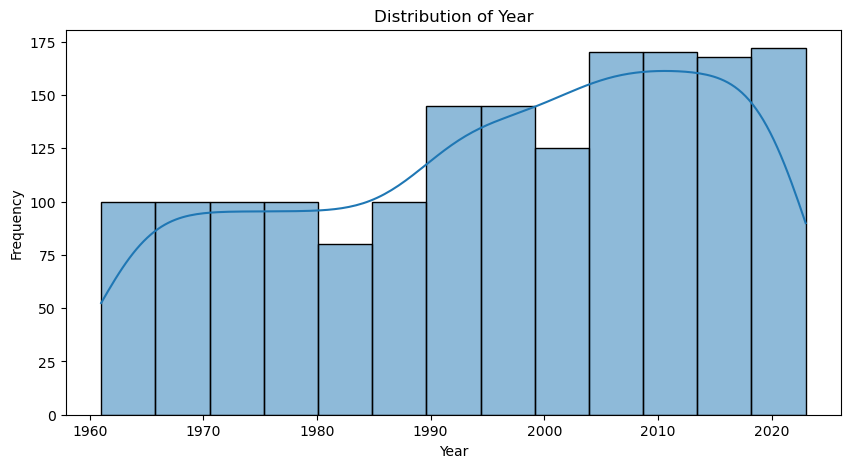

In [9]:
plt.figure(figsize=(12, 6))
if 'Value' in df.columns:
    sns.histplot(df['Value'], kde=True)
    plt.title('Distribution of Value')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

if 'Year' in df.columns and pd.api.types.is_numeric_dtype(df['Year']):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Year'], kde=True)
    plt.title('Distribution of Year')
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.show()

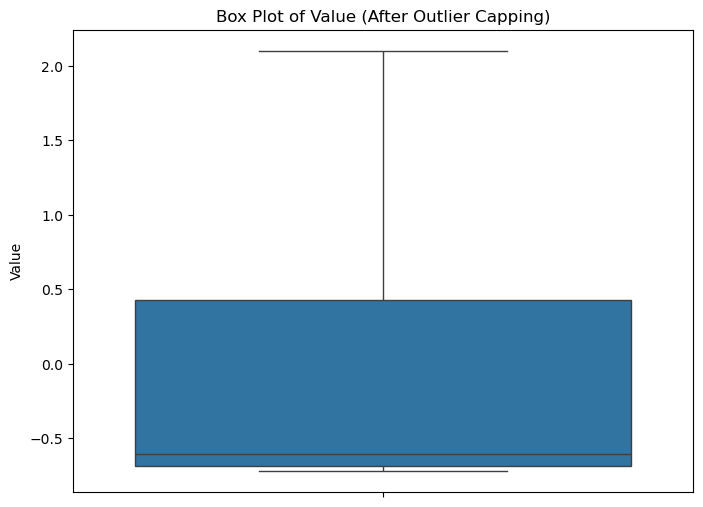

In [10]:
if 'Value' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df['Value'])
    plt.title('Box Plot of Value (After Outlier Capping)')
    plt.ylabel('Value')
    plt.show()

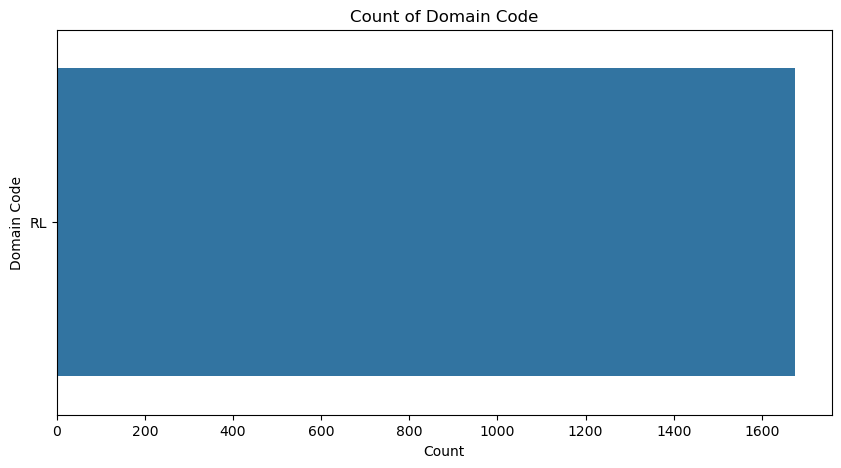

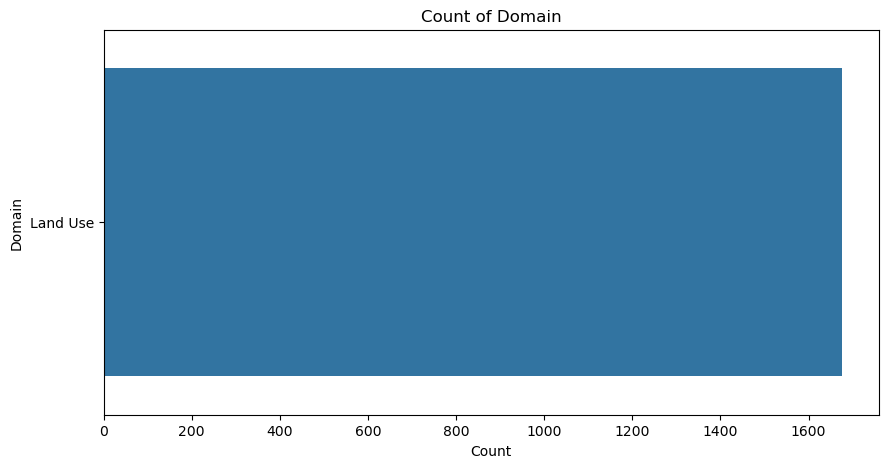

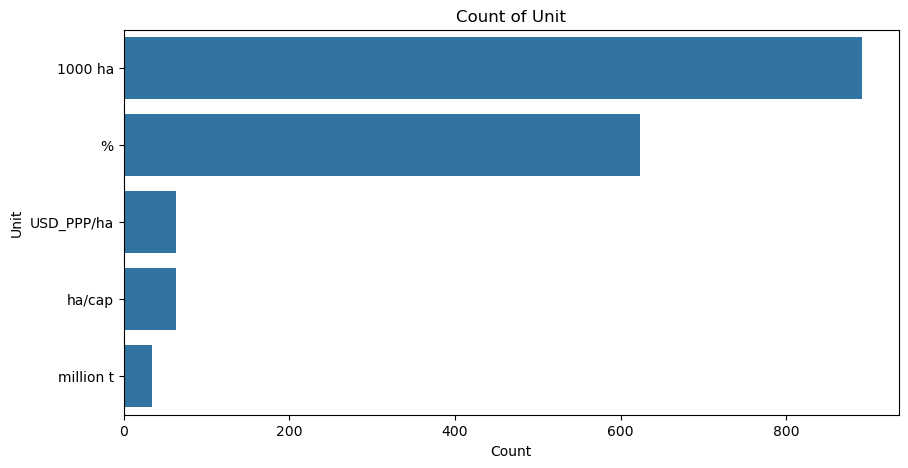

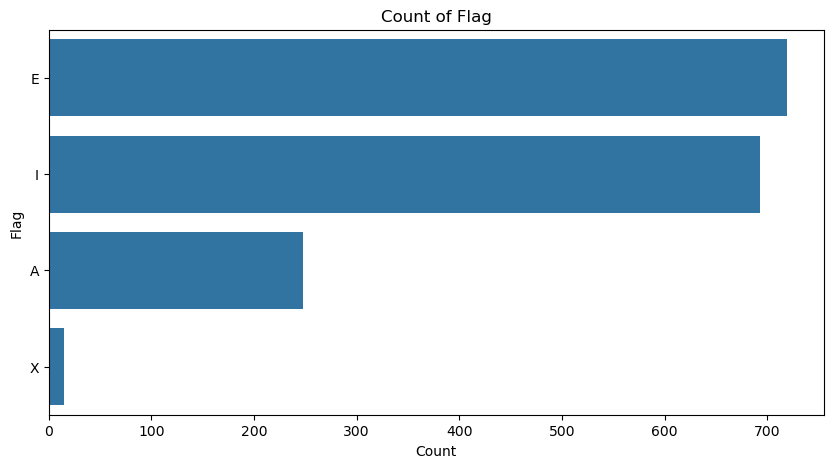

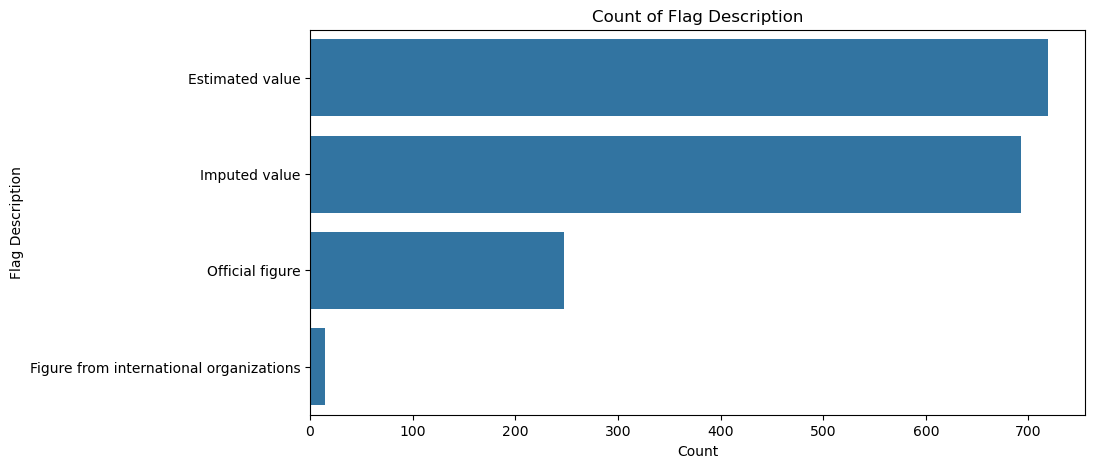

In [11]:
# Assuming 'Area', 'Item', 'Element' were original categorical columns
# We will try to plot them if they still exist or if we have a copy of the original data.
# For now, let's plot some of the encoded features if they exist.
# This part would typically be done *before* extensive encoding if you want to see original distributions easily.
# For the cleaned_df, if there are still object type columns, we can plot them:
remaining_object_cols = df.select_dtypes(include='object').columns
for col in remaining_object_cols:
    if df[col].nunique() < 20: # Plot only if number of unique values is manageable
        plt.figure(figsize=(10, 5))
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Count of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()

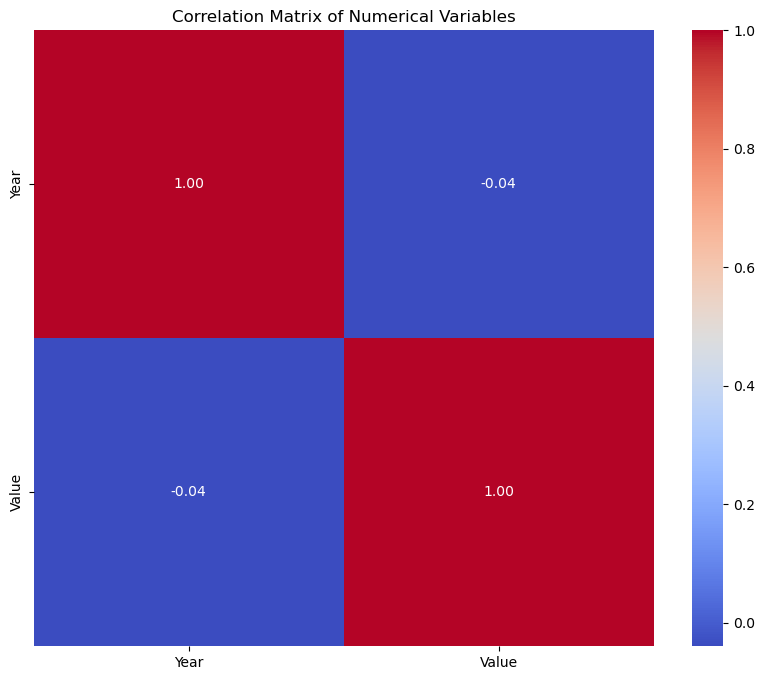

In [12]:
# Select numerical columns for correlation, excluding ID or unnecessary metadata
# Ensure to include 'Value' and 'Year' if they are numerical and relevant.
numerical_cols_for_corr = df.select_dtypes(include=np.number).columns.tolist()
# Exclude high cardinality ID-like columns if they remain
numerical_cols_for_corr = [col for col in numerical_cols_for_corr if not 'ID' in col and not 'Code' in col]


if len(numerical_cols_for_corr) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numerical_cols_for_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Variables')
    plt.show()
else:
    print("\nNot enough numerical columns to generate a meaningful correlation heatmap.")

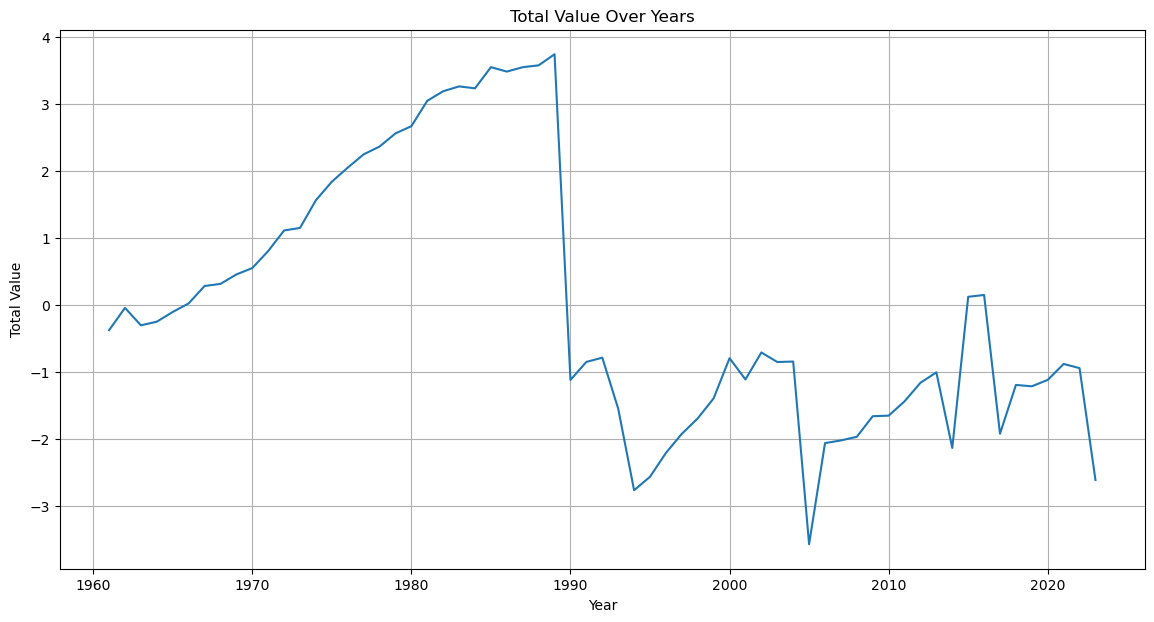

In [13]:
if 'Year' in df.columns and 'Value' in df.columns and pd.api.types.is_numeric_dtype(df['Year']):
    # Group by Year and sum the Value to see trends
    yearly_trends = df.groupby('Year')['Value'].sum().reset_index()
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=yearly_trends, x='Year', y='Value')
    plt.title('Total Value Over Years')
    plt.xlabel('Year')
    plt.ylabel('Total Value')
    plt.grid(True)
    plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler # Assuming this was used for df_processed

# --- Start with your df_processed (or whatever your final cleaned DataFrame is named) ---
# For demonstration purposes, let's assume 'df' here is your preprocessed data from previous steps
# If your final cleaned DataFrame is named 'df_processed', replace 'df' with 'df_processed'

# Ensure 'Value' is numeric and handle any potential NaNs if they reappeared or were not fully handled
# This is a safeguard; ideally, your cleaning steps would have already handled this.
if 'Value' in df.columns:
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    # Drop rows where 'Value' is NaN, as we can't train on a missing target
    df.dropna(subset=['Value'], inplace=True)
    print(f"Dropped rows with NaN 'Value'. New shape: {df.shape}")

# Define features (X) and target (y)
# First, identify all potential feature columns.
# We need to ensure these columns are numeric and exclude target and ID/metadata columns.

# Get all numeric columns from the processed DataFrame
potential_features = df.select_dtypes(include=np.number).columns.tolist()

# Define columns to exclude from features (target, ID columns, and other non-predictive columns)
features_to_exclude_from_model = [
    'Value',            # The target variable
    'Area Code',        # Typically an identifier, not a feature
    'Item Code',        # Identifier
    'Element Code',     # Identifier
    'Year Code',        # Identifier
    # Add any other columns that are not useful as features, e.g., 'Unit' or 'Flag'
    # if they were not dropped or encoded and still remain as numeric (unlikely but possible)
]

# Filter out the excluded columns from the potential features list
X_cols = [col for col in potential_features if col not in features_to_exclude_from_model]

# Create the features DataFrame (X) and target Series (y)
# IMPORTANT: Both X and y are created from the SAME 'df' DataFrame
X = df[X_cols]
y = df['Value']

# Further checks for consistency and potential issues in X
# 1. Drop columns from X that might have become all NaN after row dropping (e.g., if a column was mostly NaNs)
X = X.dropna(axis=1, how='all')
print(f"Shape after dropping all-NaN columns from X: {X.shape}")

# 2. Drop columns from X that have only one unique value (constant features)
# These don't provide predictive power and can sometimes cause issues.
X = X.loc[:, X.nunique() > 1]
print(f"Shape after dropping constant columns from X: {X.shape}")

if X.empty:
    print("\nError: No suitable numerical features found for modeling after exclusions and checks.")
    print("Available numeric columns in original df:", df.select_dtypes(include=np.number).columns.tolist())
    exit()

# Ensure that X and y still have the same number of rows after all preceding steps
if X.shape[0] != y.shape[0]:
    print(f"\nCritical Error: X and y still have inconsistent numbers of samples: X has {X.shape[0]} rows, y has {y.shape[0]} rows.")
    print("This indicates an issue in prior data preparation where rows were dropped/added inconsistently.")
    print("Attempting to re-align indices (use with caution, better to fix source of inconsistency):")
    # This is a fallback. The best fix is to ensure data preparation is consistent.
    common_index = X.index.intersection(y.index)
    X = X.loc[common_index]
    y = y.loc[common_index]
    print(f"Shapes after re-aligning indices: X {X.shape}, y {y.shape}")
    if X.shape[0] == 0:
        print("Re-alignment resulted in empty dataframes. Check your original data cleaning.")
        exit()


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
print("\nLinear Regression model trained successfully.")

# Make predictions on the test set
y_pred = model.predict(X_test)

print("\nPredictions generated successfully.")

Dropped rows with NaN 'Value'. New shape: (1675, 40)
Shape after dropping all-NaN columns from X: (1675, 2)
Shape after dropping constant columns from X: (1675, 1)

Shape of X_train: (1340, 1)
Shape of X_test: (335, 1)
Shape of y_train: (1340,)
Shape of y_test: (335,)

Linear Regression model trained successfully.

Predictions generated successfully.



Model Evaluation:
Mean Squared Error (MSE): 1.07
Root Mean Squared Error (RMSE): 1.03
R-squared (R2): -0.01


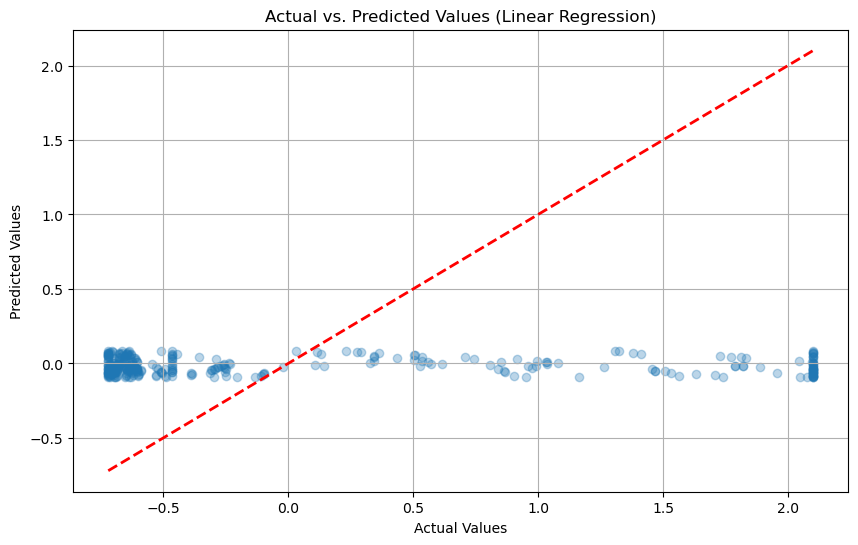

In [18]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.grid(True)
plt.show()

In [19]:
def load_data(filepath):
    """Loads a CSV file into a pandas DataFrame."""
    try:
        df = pd.read_csv(filepath)
        print(f"Dataset '{filepath}' loaded successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: {filepath} not found. Please ensure the file is in the correct directory.")
        return None

def handle_missing_values(df, threshold_cols=0.5, numerical_strategy='median', categorical_strategy='mode'):
    """Handles missing values in the DataFrame."""
    print("\nHandling missing values...")
    initial_shape = df.shape

    # Drop columns with more than 'threshold_cols' missing values
    df = df.dropna(thresh=threshold_cols * len(df), axis=1)
    print(f"Shape after dropping columns with >{threshold_cols*100}% missing values: {df.shape}")

    numerical_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(include='object').columns

    # Impute numerical missing values
    if numerical_strategy == 'median':
        for col in numerical_cols:
            if df[col].isnull().any():
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with median: {median_val}")
    elif numerical_strategy == 'mean':
        for col in numerical_cols:
            if df[col].isnull().any():
                mean_val = df[col].mean()
                df[col].fillna(mean_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with mean: {mean_val}")

    # Impute categorical missing values
    if categorical_strategy == 'mode':
        for col in categorical_cols:
            if df[col].isnull().any():
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with mode: {mode_val}")

    print("Missing values after imputation:")
    print(df.isnull().sum().loc[lambda x: x > 0]) # Only show columns with missing values
    return df

def clean_and_transform_data(df):
    """Applies data type conversions, outlier handling, and encoding."""
    print("\nApplying data cleaning and transformations...")

    # Convert 'Value' column to numeric, coercing errors and filling NaNs
    if 'Value' in df.columns:
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        if df['Value'].isnull().any():
            median_value_val = df['Value'].median()
            df['Value'].fillna(median_value_val, inplace=True)
            print(f"  Converted 'Value' to numeric and filled new NaNs with median: {median_value_val}")

    # Strip whitespace from object columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
    print("  Trimmed whitespace from categorical columns.")

    # Outlier handling for 'Value' column (capping)
    if 'Value' in df.columns and pd.api.types.is_numeric_dtype(df['Value']):
        Q1 = df['Value'].quantile(0.25)
        Q3 = df['Value'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df['Value'] = np.where(df['Value'] < lower_bound, lower_bound, df['Value'])
        df['Value'] = np.where(df['Value'] > upper_bound, upper_bound, df['Value'])
        print(f"  Capped outliers in 'Value' column using IQR.")

    # One-hot encode suitable categorical columns
    cols_to_encode = []
    for col in ['Area', 'Item', 'Element']: # Example columns, adjust based on your df
        if col in df.columns and df[col].nunique() < 100 and df[col].dtype == 'object':
            cols_to_encode.append(col)

    if cols_to_encode:
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
        print(f"  Applied one-hot encoding to: {cols_to_encode}")
    else:
        print("  No suitable categorical columns found for one-hot encoding.")

    # Scale numerical features
    numerical_cols_for_scaling = df.select_dtypes(include=np.number).columns.tolist()
    cols_to_exclude_from_scaling = ['Value', 'Area Code', 'Item Code', 'Element Code', 'Year Code'] # Exclude target and IDs
    numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col not in cols_to_exclude_from_scaling]

    if numerical_cols_for_scaling:
        scaler = StandardScaler()
        df[numerical_cols_for_scaling] = scaler.fit_transform(df[numerical_cols_for_scaling])
        print(f"  Scaled numerical columns: {numerical_cols_for_scaling}")
    else:
        print("  No numerical columns found for scaling with current criteria.")

    return df

# How to use these functions:
# df_raw = load_data('FAOSTAT_data_en_7-29-2025.csv')
# if df_raw is not None:
#     df_cleaned = handle_missing_values(df_raw.copy())
#     df_processed = clean_and_transform_data(df_cleaned.copy())
#     print("\nFinal processed DataFrame head:")
#     print(df_processed.head())

Dataset 'FAOSTAT_data_en_7-29-2025.csv' loaded successfully.

Handling missing values...
Shape after dropping columns with >50.0% missing values: (1675, 14)
Missing values after imputation:
Series([], dtype: int64)

Applying data cleaning and transformations...
  Trimmed whitespace from categorical columns.
  Capped outliers in 'Value' column using IQR.
  Applied one-hot encoding to: ['Area', 'Item', 'Element']
  Scaled numerical columns: ['Area Code (M49)', 'Year']

Final processed DataFrame head:
  Domain Code    Domain  Area Code (M49)  Element Code  Item Code  Year Code  \
0          RL  Land Use              0.0          5110       6600       1961   
1          RL  Land Use              0.0          5110       6600       1962   
2          RL  Land Use              0.0          5110       6600       1963   
3          RL  Land Use              0.0          5110       6600       1964   
4          RL  Land Use              0.0          5110       6600       1965   

       Year    

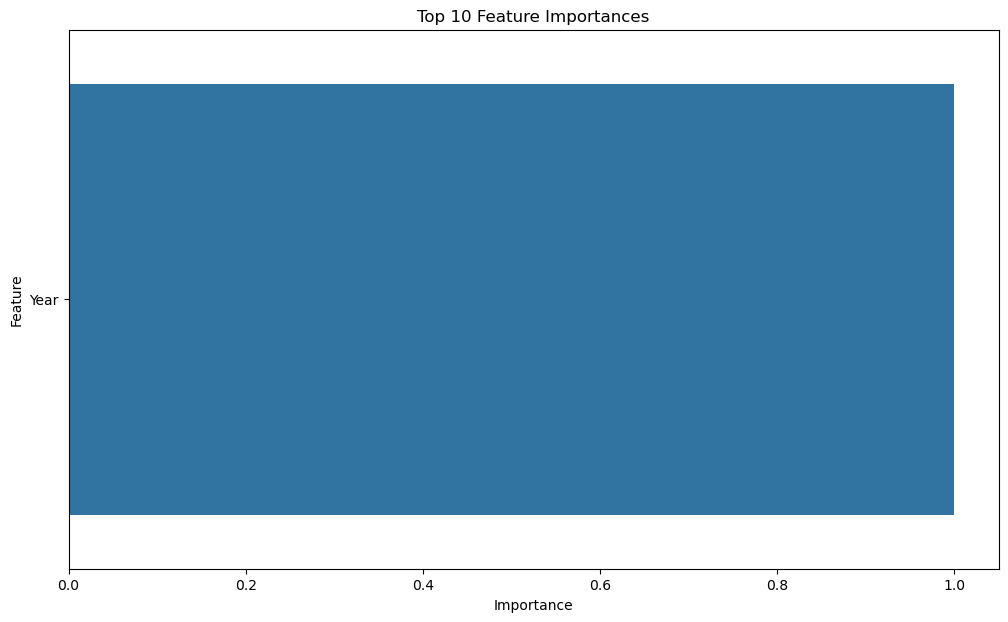

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Added for imputation option
from sklearn.ensemble import RandomForestRegressor # For the innovation part


# --- Data Loading Function ---
def load_data(filepath):
    """Loads a CSV file into a pandas DataFrame."""
    try:
        df = pd.read_csv(filepath)
        print(f"Dataset '{filepath}' loaded successfully.")
        return df
    except FileNotFoundError:
        print(f"Error: {filepath} not found. Please ensure the file is in the correct directory.")
        return None

# --- Missing Value Handling Function ---
def handle_missing_values(df, threshold_cols=0.5, numerical_strategy='median', categorical_strategy='mode'):
    """Handles missing values in the DataFrame."""
    print("\nHandling missing values...")
    initial_shape = df.shape

    # Drop columns with more than 'threshold_cols' missing values
    df = df.dropna(thresh=threshold_cols * len(df), axis=1)
    print(f"Shape after dropping columns with >{threshold_cols*100}% missing values: {df.shape}")

    numerical_cols = df.select_dtypes(include=np.number).columns
    categorical_cols = df.select_dtypes(include='object').columns

    # Impute numerical missing values
    if numerical_strategy == 'median':
        for col in numerical_cols:
            if df[col].isnull().any():
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with median: {median_val}")
    elif numerical_strategy == 'mean':
        for col in numerical_cols:
            if df[col].isnull().any():
                mean_val = df[col].mean()
                df[col].fillna(mean_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with mean: {mean_val}")

    # Impute categorical missing values
    if categorical_strategy == 'mode':
        for col in categorical_cols:
            if df[col].isnull().any():
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                # print(f"  Filled missing values in '{col}' with mode: {mode_val}")

    print("Missing values after imputation:")
    print(df.isnull().sum().loc[lambda x: x > 0]) # Only show columns with missing values
    return df

# --- Cleaning and Transformation Function ---
def clean_and_transform_data(df):
    """Applies data type conversions, outlier handling, and encoding."""
    print("\nApplying data cleaning and transformations...")

    # Convert 'Value' column to numeric, coercing errors and filling NaNs
    if 'Value' in df.columns:
        df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
        if df['Value'].isnull().any():
            median_value_val = df['Value'].median()
            df['Value'].fillna(median_value_val, inplace=True)
            print(f"  Converted 'Value' to numeric and filled new NaNs with median: {median_value_val}")

    # Strip whitespace from object columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)
    print("  Trimmed whitespace from categorical columns.")

    # Outlier handling for 'Value' column (capping)
    if 'Value' in df.columns and pd.api.types.is_numeric_dtype(df['Value']):
        Q1 = df['Value'].quantile(0.25)
        Q3 = df['Value'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df['Value'] = np.where(df['Value'] < lower_bound, lower_bound, df['Value'])
        df['Value'] = np.where(df['Value'] > upper_bound, upper_bound, df['Value'])
        print(f"  Capped outliers in 'Value' column using IQR.")

    # One-hot encode suitable categorical columns
    cols_to_encode = []
    # Adjust these columns based on your actual data
    for col in ['Area', 'Item', 'Element', 'Year']: # Added 'Year' as it can be numeric or categorical
        if col in df.columns:
            if df[col].dtype == 'object' and df[col].nunique() < 100: # For categorical string columns
                cols_to_encode.append(col)
            elif pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() < 50: # For numeric columns with few unique values (might be categorical)
                 # You might choose to one-hot encode numeric columns with few unique values like 'Year' if it represents categories
                 # For FAOSTAT, 'Year' is usually treated as a numerical/time feature, so exclude from one-hot here if it's meant to be continuous.
                 pass # Don't encode year if it's numeric and continuous.
                 # If you intend to treat numeric 'Year' as categorical, uncomment this:
                 # cols_to_encode.append(col)

    if cols_to_encode:
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
        print(f"  Applied one-hot encoding to: {cols_to_encode}")
    else:
        print("  No suitable categorical columns found for one-hot encoding.")

    # Scale numerical features
    numerical_cols_for_scaling = df.select_dtypes(include=np.number).columns.tolist()
    # Exclude target ('Value') and any ID/already encoded columns from scaling
    cols_to_exclude_from_scaling = ['Value', 'Area Code', 'Item Code', 'Element Code', 'Year Code'] # Adjust based on your data
    numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col not in cols_to_exclude_from_scaling]

    if numerical_cols_for_scaling:
        scaler = StandardScaler()
        df[numerical_cols_for_scaling] = scaler.fit_transform(df[numerical_cols_for_scaling])
        print(f"  Scaled numerical columns: {numerical_cols_for_scaling}")
    else:
        print("  No numerical columns found for scaling with current criteria.")

    return df

# --- Main execution flow to create df_processed ---
file_path = 'FAOSTAT_data_en_7-29-2025.csv'
df_raw = load_data(file_path)

if df_raw is not None:
    df_cleaned = handle_missing_values(df_raw.copy())
    df_processed = clean_and_transform_data(df_cleaned.copy())
    print("\nFinal processed DataFrame head:")
    print(df_processed.head())
    print(f"Shape of df_processed: {df_processed.shape}")
    print("\nCheck for any remaining NaNs in df_processed after full pipeline:")
    print(df_processed.isnull().sum().loc[lambda x: x > 0]) # Show only columns with NaNs


    # --- Your RandomForestRegressor code (with the fixes for NaNs in X) ---
    features_to_exclude_from_model = [
        'Value',            # The target variable
        'Area Code',        # Typically an identifier
        'Item Code',        # Identifier
        'Element Code',     # Identifier
        'Year Code',        # Identifier
        'Unit',             # Exclude if it's an object and not encoded, or if encoded to many columns
        'Flag',             # Exclude if it's an object and not encoded
        'Note',             # Exclude, usually text
        'Flag Description', # Exclude, usually text
        'Domain Code',      # Identifier/categorical, exclude if not useful as feature
        'Domain',           # Categorical, exclude if not useful as feature
    ]

    # Ensure 'Value' is numeric and drop rows where it's NaN (target cannot be NaN)
    # This was already done above in clean_and_transform_data for df_processed, but it's good to re-check
    # especially if `df_processed` was passed from outside this immediate block.
    if 'Value' in df_processed.columns:
        df_processed['Value'] = pd.to_numeric(df_processed['Value'], errors='coerce')
        df_processed.dropna(subset=['Value'], inplace=True)
        print(f"Dropped rows with NaN 'Value' before model training. Current df_processed shape: {df_processed.shape}")

    # Select only numerical columns for X initially
    X = df_processed.select_dtypes(include=np.number).copy() # Use .copy() to avoid SettingWithCopyWarning

    # Remove target and other explicitly excluded ID/metadata columns from features
    cols_to_drop_from_X = [col for col in features_to_exclude_from_model if col in X.columns]
    X.drop(columns=cols_to_drop_from_X, errors='ignore', inplace=True)
    print(f"Shape of X after dropping excluded columns: {X.shape}")

    y = df_processed['Value'] # Y is derived directly from df_processed AFTER value NaNs are handled

    # --- CRITICAL STEP: Handle remaining NaNs in X ---
    # Option 1: Drop rows with any NaN values in X (simplest)
    initial_X_rows = X.shape[0]
    X.dropna(inplace=True)
    rows_dropped_from_X = initial_X_rows - X.shape[0]
    if rows_dropped_from_X > 0:
        print(f"Dropped {rows_dropped_from_X} rows from X due to NaNs.")
    print(f"Shape of X after dropping rows with NaNs: {X.shape}")

    # Align y to X's index after dropping rows from X
    y = y.loc[X.index]
    print(f"Shape of y after aligning with X's index: {y.shape}")

    # Drop any columns from X that ended up with all NaNs or are constant
    X = X.dropna(axis=1, how='all')
    X = X.loc[:, X.nunique() > 1] # Remove constant columns
    print(f"Final shape of X before splitting: {X.shape}")


    if X.empty:
        print("\nError: X is empty after feature selection and NaN handling. Cannot train model.")
    else:
        # Ensure X and y have consistent samples AFTER all cleaning and alignment
        if X.shape[0] != y.shape[0]:
            print(f"\nCritical Error: X and y still have inconsistent numbers of samples: X has {X.shape[0]} rows, y has {y.shape[0]} rows.")
            # As a last resort, try re-aligning indices explicitly one more time
            common_index = X.index.intersection(y.index)
            X = X.loc[common_index]
            y = y.loc[common_index]
            print(f"Shapes after re-aligning indices: X {X.shape}, y {y.shape}")
            if X.shape[0] == 0:
                print("Re-alignment resulted in empty dataframes. Check your original data cleaning process.")
                exit()


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print(f"\nShape of X_train: {X_train.shape}")
        print(f"Shape of X_test: {X_test.shape}")
        print(f"Shape of y_train: {y_train.shape}")
        print(f"Shape of y_test: {y_test.shape}")

        # Initialize and train RandomForestRegressor
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        print("\nRandomForestRegressor model trained successfully.")

        # Make predictions
        y_pred_rf = rf_model.predict(X_test)

        # Evaluate RandomForestRegressor
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        rmse_rf = np.sqrt(mse_rf)
        r2_rf = r2_score(y_test, y_pred_rf)

        print(f"\nRandomForestRegressor Evaluation:")
        print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
        print(f"R-squared (R2): {r2_rf:.2f}")

        # Feature Importance (for tree-based models)
        if not X.empty:
            feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
            print("\nTop 10 Feature Importances (RandomForestRegressor):")
            print(feature_importances.head(10))

            plt.figure(figsize=(12, 7))
            sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
            plt.title('Top 10 Feature Importances')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.show()


RandomForestRegressor model trained successfully.

RandomForestRegressor Evaluation:
Mean Squared Error (MSE): 503521.58
Root Mean Squared Error (RMSE): 709.59
R-squared (R2): -0.10

Top 10 Feature Importances (RandomForestRegressor):
Year    1.0
dtype: float64


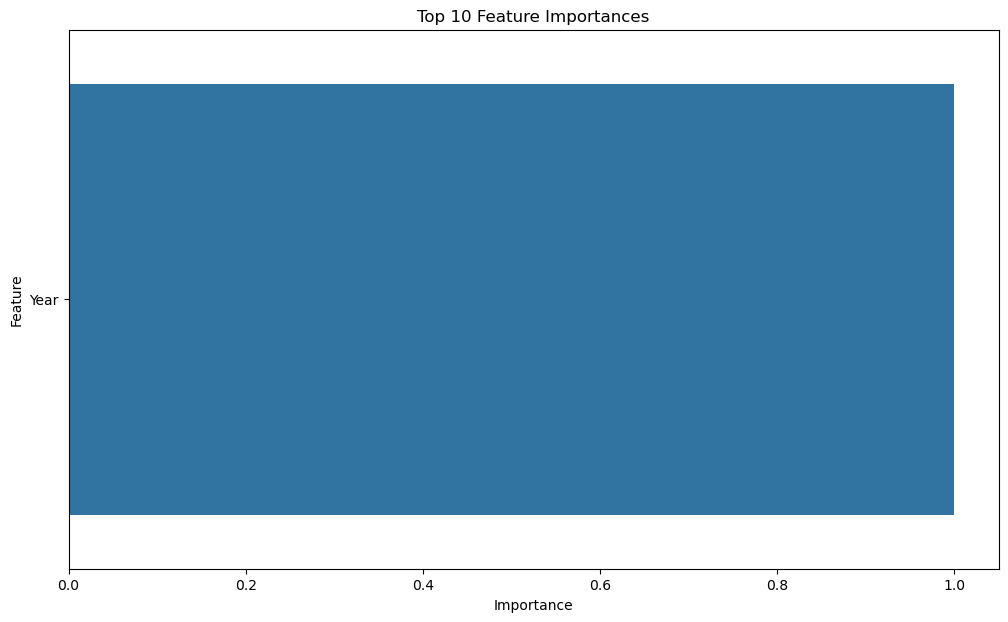

In [25]:
from sklearn.ensemble import RandomForestRegressor

# Assuming df_processed is the final preprocessed DataFrame
# Re-define X and y based on df_processed for modeling
# Drop non-feature columns
features_to_exclude_from_model = [
    'Value', 'Area Code', 'Item Code', 'Element Code', 'Year Code', # Common IDs/target
    'Unit', 'Flag' # Other non-numeric/non-feature columns that might remain
]
# Ensure only numeric columns are included in X and remove potential ID columns
X = df_processed.select_dtypes(include=np.number).drop(columns=[col for col in features_to_exclude_from_model if col in df_processed.columns], errors='ignore')
y = df_processed['Value']

# Drop any columns from X that ended up with all NaNs or are constant (after scaling, etc.)
X = X.dropna(axis=1, how='all')
X = X.loc[:, X.nunique() > 1] # Remove constant columns

if X.empty:
    print("\nError: X is empty after feature selection. Cannot train model.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
    rf_model.fit(X_train, y_train)
    print("\nRandomForestRegressor model trained successfully.")

    # Make predictions
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate RandomForestRegressor
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    print(f"\nRandomForestRegressor Evaluation:")
    print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
    print(f"R-squared (R2): {r2_rf:.2f}")

    # Feature Importance (for tree-based models)
    if not X.empty:
        feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
        print("\nTop 10 Feature Importances (RandomForestRegressor):")
        print(feature_importances.head(10))

        plt.figure(figsize=(12, 7))
        sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index)
        plt.title('Top 10 Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

In [26]:
# Assuming 'df_processed' is your final cleaned and transformed DataFrame

# Define the path and filename for your new CSV file
output_filepath = 'FAOSTAT_data_processed.csv'

# Save the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
df_processed.to_csv(output_filepath, index=False)

print(f"Final processed dataset saved to '{output_filepath}' successfully!")

Final processed dataset saved to 'FAOSTAT_data_processed.csv' successfully!
